# Photometry in Python - Photutils, DAOFIND, and Aperture Photometry

This notebook is based on a series created by Stuart Littlefair at the University of Sheffield. 
It also makes use of 'phot_helpers.py', a set of useful scripts created by Stuart Littlefair for photometry.


## Steps

At the end of this notebook you should be able to measure magnitudes for stars in your calibrated Nickel images. 

The steps are:
1. finding the stars in our image;
1. measuring instrumental magnitudes (photometry);
1. matching our stars against a sky-survey, to give us a pre-calibrated magnitude for many stars;
1. calculating the offset between instrumental and calibrated magnitudes, and applying to all stars in our image.


# Photometry with Photutils

Many tools exist to perform photometry (IRAF, GAIA, AstroImageJ etc.)
We are going to be using the Python package [photutils](http://photutils.readthedocs.org/en/latest/) to do most of the heavy lifting for us.

If you do not have photutils already installed, the code cell below will install it. Run this cell, and if there are any **errors**, ask for help (warnings are ok/expected).

In [1]:
import sys
!{sys.executable} -m pip install photutils

In [2]:
## if this code cell runs without error, you have successfully installed photutils!
import photutils as p

In [3]:
# A function to perform aperture photometry
from photutils.utils import calc_total_error
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
import astropy.stats as st
import warnings
from astropy.wcs import WCS
def aperture_photometry(data, header, sources, aperture_radius, sky_inner_radius, sky_outer_radius):
    """
    Calculate Aperture Photometry on a list of sources

    Parameters
    ----------
    data:  `np.ndarray`
        A 2D array of pixel values of your data. From a FITS file, you can create this array with
        `fits.getdata`.

    header: `~astropy.fits.Header`
        A FITS Header object. From a FITS file, you can create this object with
        `fits.getheader`.

    sources: `~astropy.table.Table`
        A table of detected sources for the image. Usually, `photutils.DAOStarFinder` would be
        used to create this list.

    aperture_radius: float
        Radius of the target aperture, in pixels

    sky_inner_radius: float
        Radius of the inner aperture that makes up the sky annulus

    sky_outer_radius: float
        Radius of the outer aperture that makes up the sky annulus

    Returns
    -------
    phot_table: `~astropy.table.Table`
        A table of measurements for each source, including instrumental magnitude and error.
    """
    # make apertures around sources, and annuli for sky estimation
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=aperture_radius)
    sky_annulus = CircularAnnulus(positions,
                                    r_in=sky_inner_radius, r_out=sky_outer_radius)
    annulus_masks = sky_annulus.to_mask(method='center')

    # aperture photometry - calculates total counts in apertures, with errors
    # calc_total_error uses CCD SNR equation 
    error_arr = calc_total_error(data, 12.0, egain)
    phot_table = p.aperture.aperture_photometry(data, apertures, error=error_arr)

    # calculate the Sky background. Because the sky annulus might have other
    # stars inside it, we will take a CLIPPED MEAN of the counts in the annulus
    # to try and reject the contribution from stars.
    bkg_mean = []
    for mask in annulus_masks:
        annulus_data = mask.multiply(data)
        annulus_data_1d = annulus_data[mask.data > 0]
        mean_sigclip, _, _ = st.sigma_clipped_stats(annulus_data_1d)
        bkg_mean.append(mean_sigclip)

    # now we know the mean sky counts. We multiply by ratio of annulus area to
    # target aperture area. This gives expected number of sky counts in target
    # aperture.
    bkg_mean = np.array(bkg_mean)
    phot_table['sky_mean'] = bkg_mean
    phot_table['aper_bkg'] = bkg_mean * apertures.area
    phot_table['aper_sum_bksub'] = phot_table['aperture_sum'] - phot_table['aper_bkg']

    # Tricky bit now! We want to know what Right Ascension and Declination
    # each pixel corresponds to. We will use the information in the FITS header
    # (the so-called "World Coordinate System") to work this out. 
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        wcs = WCS(header)
    ra, dec = wcs.all_pix2world(phot_table['xcenter'], phot_table['ycenter'], 0)
    phot_table['RA'] = ra
    phot_table['DEC'] = dec

    # Calculate Instrumental Magnitude and Error
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        phot_table['instrumental_mag'] = -2.5*np.log10(phot_table['aper_sum_bksub'] / header['EXPTIME'])
    phot_table['e_instrumental_mag'] = phot_table['aperture_sum_err'] / phot_table['aper_sum_bksub']

    return phot_table

In [4]:
# We will use this function later to measure FWHM in our images
def measure_FWHM(data, sources):
    # averagely bright stars
    lims = np.percentile(sources['flux'], (55, 65))
    mask = reduce(
        np.logical_and,
        (sources['flux'] > lims[0], sources['flux'] < lims[1],
         sources['xcentroid'] > 15, sources['ycentroid'] > 15,
         sources['xcentroid'] < data.shape[1]-15, 
         sources['ycentroid'] < data.shape[0]-15
        )
    )

    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    tree = KDTree(positions)
    # nearest neighbours
    dist, ind = tree.query(positions, 2)

    # most isolated star of proper brightness
    idx = dist[:, 1][mask].argmax()
    location = positions[mask][idx]
    cutout = Cutout2D(data, location.T, 15)

    fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
    norm = ImageNormalize(cutout.data, interval=AsymmetricPercentileInterval(1, 99))
    axis[0].imshow(cutout.data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
    axis[0].set_xlabel('X')
    axis[0].set_ylabel('Y')

    xc, yc = centroid_com(cutout.data)
    x = np.arange(15) - xc
    y = np.arange(15) - yc
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    axis[1].plot(R.ravel(), cutout.data.ravel(), '.')
    axis[1].set_xlabel('Distance from centre of star')
    axis[1].set_ylabel('Counts')


# Read in your image

Using the code cell below, read in one of your pre-calibrated Nickel images with plenty of stars. A good choice would be a long exposure V-band image. We're going to read the image into an array called `data` and read the header from the FITS file into a variable called `header`. 


In [65]:
from astropy.io import fits,ascii
import numpy as np
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import AsymmetricPercentileInterval
from matplotlib import pyplot as plt
from functools import reduce
from scipy.spatial import KDTree
from astropy.nddata import Cutout2D
from photutils.centroids import centroid_com

# We need to set the gain of our CCD to allow us to measure errors correctly later
# For the Nickel, gain is 2 e/ADU
egain = 2.0
ifile = '/Users/evan/Documents/Research/galaxies/2023-07-20/Reduced/Data_files/d1068_os_bs_ff_bp_crj_crj.fits'
data, header = fits.getdata(ifile,header=True)

# Creating a Source List

The first step is to detect our sources. We will do this using an algorithm called DAOFIND ([Stetson 1987, PASP, 99, 191](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract)). DAOFIND looks for bright regions in the image that have a peak brightness greater than some threshold and that have a size and shape similar to a Gaussian of specified FWHM.

Stars in our image will stand out above the background, and DAOFIND will find them, but we need to know what threshold to use. One way of doing this is to measure the statistics of the **background** in our image. If we measure the average value of the background, and the amount the background varies, we can look for regions that are significantly brighter than background pixels. 

Below we will do that using a "sigma-clipped" mean - this estimates the average background and the standard deviation. We then throw away all the pixels more than 3 standard deviations (sigma) away from the mean, and repeat the process. We carry on until no pixels are more than 3 standard deviations away from the average value, then calculate the mean, median and standard deviation of the remaining pixels.

You may want to tweak this value of sigma until you're happy with the sky level.

In [66]:
# import sigma_clipping function from astropy
from astropy.stats import sigma_clipped_stats

mean_background, median_background, background_standard_deviation = sigma_clipped_stats(data, sigma=3.0)

print("The background has an average value of {:.1f} and a standard deviation of {:.1f} counts".format(
    mean_background, background_standard_deviation))

The background has an average value of 18.6 and a standard deviation of 6.7 counts


# Finding Stars

Now we know how bright our background is, and how much it varies, let's look for stars that are brighter than the background plus 5 standard deviations. That should be enough that we don't identify bright background pixels as stars by accident. The DAOFIND algorithm needs a guess for how big the stars are - as a Gaussian FWHM - we'll guess at 3 pixels for now, but you can tweak this further.

In [74]:
from photutils.detection import DAOStarFinder

# make a star finder object to look for stars with FWHM~3 pixels that are more than 5-sigma above background
daofind = DAOStarFinder(fwhm=7.0, threshold=5*background_standard_deviation)

# Mask the data to remove the edges/corners
mask=np.ma.make_mask(data,copy=True,shrink=True,dtype=bool)
mask[:,:]=False
mask[950:,0:50]=True
mask[0:50,0:50]=True
mask[:,1010:]=True

# use it to find stars. We'll subtract the background off first, so background pixels have an average value of 0
sources = daofind(data - median_background,mask=mask)

print(sources)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  649.2796554556687 ...  1.778005599975586  -0.6248328112067834
  2  522.3165726609334 ...  2.806379795074463  -1.1203661123326898
  3  825.3033325658744 ...  3.286770820617676  -1.2919235568186938
  4 209.71321761953104 ...  7.551639080047607  -2.1951030632325166
  5   33.1084557683902 ... 1.5754250288009644  -0.4934943520775662
  6  198.4478896241935 ...  4.006614685058594  -1.5069439461746394
  7  198.6080744719241 ... 3.2024049758911133   -1.263690629758902
...                ... ...                ...                  ...
 14  205.7769542755566 ...  3.108949661254883  -1.2315342254873476
 15  228.9923668704631 ... 1.0076264142990112 -0.00824885933678043
 16 172.98847056950075 ... 2.3116395473480225  -0.9098002893345651
 17  703.9827369053584 ...  8.559154510498047   -2.331077165910015
 18 237.76394504919068 ...  6.736673355102539   -2.07111372495

The ``sources`` variable contains a table of all the detected stars. There are various columns, but the ones we are interested in is the X and Y positions of the stars, which you can find with ```sources['xcentroid']``` and ```sources['ycentroid']```.

But how do we know we've found most of the stars? Or if we are mistakenly identifying bright background pixels as stars? We can inspect our sources by-eye. To make this easier, we're going to use one of the handy functions written by Stuart Littlefair 


In [75]:
# How big should we make the red apertures (in pixels)?
radius=3
# Set up the positions of stars (from DAOFIND) and the size of our apertures
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=radius)
# Normalise the image
norm = ImageNormalize(data, interval=AsymmetricPercentileInterval(5, 95))

fig = plt.figure(figsize=(15, 12))
apertures.plot(color='red', lw=1.5, alpha=0.5)
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')


# Tweak the detection settings

 The DAOFIND algorithm requires a threshold for star detection, and a typical FWHM of the stars in the images. Try different settings for these values, and see how they affect the detection of stars in your data. Make a decision about what values to use for this image.

# FWHM of stars in the image

We will also need an estimate for the FWHM of stars in the image. We can estimate this by-eye by plotting a bright, isolated, star and plotting the brightness against distance from the star's centre. 

Again, a handy tool exists to do this already. Using the plot below, figure out your FWHM in pixels. Using the Nickel plate scale you can convert it to arcseconds (you do remember the value right?)

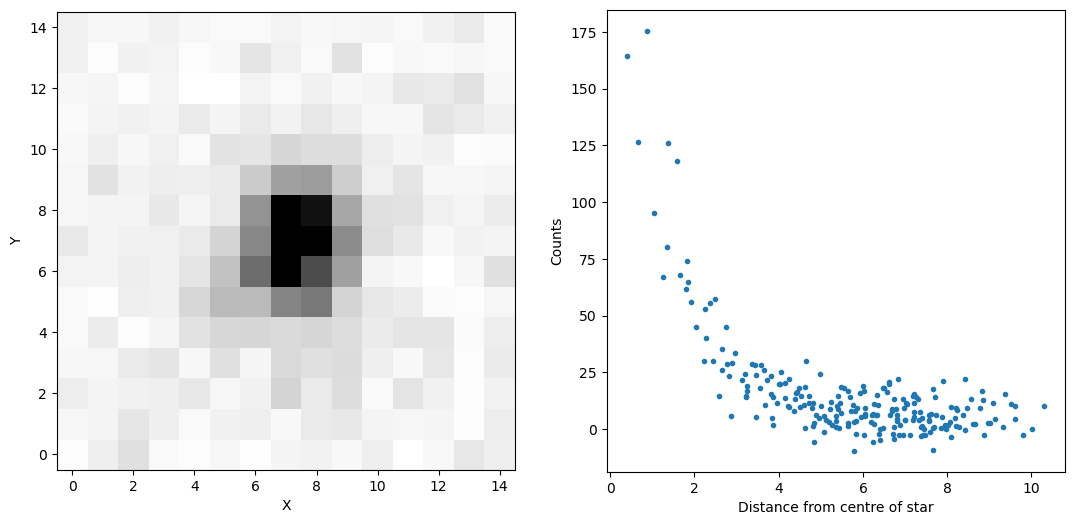

In [9]:

measure_FWHM(data, sources)

# Aperture Photometry

So, we have a list of detected sources and positions in the image, and an idea of the FWHM of stars in the image. Now we can perform aperture photometry on all of these sources. 
In brief the function performs the following steps:

1. Add up the counts from each source within a target aperture
2. Measure the sky brightness around each source using the sky annulus
3. Subtract the sky contribution from the counts in step 1.
4. Calculate instrumental magnitude from the counts and exposure time.


# Perform Aperture Photometry

You'll need to pick values for the aperture radii. 

Target apertures want to be big enough to accept a decent fraction of the flux, but not so large that the measurements are very noisy, or contaminated by nearby stars. As a rule of thumb this aperture might have a radius of 1.5-2x the FWHM.

Sky Annuli want to be wide enough to accurately measure the sky, but not so large that the annuli overlap nearby stars.

To get started, try values around 5, 10, 20 pixels for these apertures. We will tweak them later on.

If you want to view extra information about what 'aperture_photometry' is doing, you can do:

help(aperture_photometry)

In [76]:
Vmag_inst = aperture_photometry(data, header, sources, 5, 10, 20)


# Photometric Calibration

Now we have a table of instrumental magnitudes (and much besides) in it. The next step is photometric calibration. As a reminder, this involves finding the average value of the *difference* between the calibrated and instrumental magnitudes for all our stars.

Since we have instrumental magnitudes and sky positions (RA, Dec) for a number of stars, we must find the matching stars in an online catalog of calibrated magnitudes. We will use the [APASS](https://www.aavso.org/apass) catalog; a catalog which combines several other sky surveys to provide data in many filters across much of the sky. Crucially, in this case it includes B, V, r, and i magnitudes, the filters used for our photometry.

To perform the cross-matching we will use the [astroquery](https://astroquery.readthedocs.io/en/latest/) Python library, and we have our aperture photometry results in a an astropy table.

In [77]:
from astropy import units as u
from astroquery.xmatch import XMatch

Our photometry is stored as an astropy table, which is a handy object for reading and writing tabular data. These astropy tables play nicely with Jupyter notebooks, so you can simply type the name of the table in a code cell to see the table displayed in the browser.

In [78]:
Vmag_inst

id,xcenter,ycenter,aperture_sum,aperture_sum_err,sky_mean,aper_bkg,aper_sum_bksub,RA,DEC,instrumental_mag,e_instrumental_mag
,pix,pix,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,649.2796554556687,139.51727722560906,1940.916245745593,110.81602641204645,18.69888991182541,1468.6073794318752,472.3088663137178,237.9843705619885,32.987313353317845,-4.185565245875797,0.2346261828132611
2,522.3165726609334,152.46916360056076,2872.300961350502,112.89767058124568,18.677967434181078,1466.964131880317,1405.336829470185,237.99985836937074,32.98548277273295,-5.369451069763517,0.08033495473381164
3,825.3033325658744,194.88485447476555,2337.0544069690945,111.70613569497024,18.486743275453446,1451.9454215741264,885.1089853949682,237.96255513161262,32.98231587635218,-4.867491874036914,0.12620608031125438
4,209.71321761953104,209.96475602488502,3551.3206410336434,114.39140658472459,18.703861809271206,1468.997871344128,2082.3227696895156,238.03786747926986,32.97833713275036,-5.796370120129462,0.054934522279550785
5,33.1084557683902,238.36534237416174,1679.432195413395,110.22454176748481,18.092628528103152,1420.9917217004495,258.4404737129455,238.0593574199616,32.97471438112325,-3.530901321041146,0.4264987607549164
6,198.4478896241935,246.31160622133217,2693.647685221329,112.5013664644966,18.14015596849702,1424.724518140082,1268.9231670812471,238.039074292613,32.974558609899745,-5.258588316224081,0.08865892702019941
...,...,...,...,...,...,...,...,...,...,...,...
15,228.9923668704631,739.6054161736289,1765.9685002401857,110.42064035103904,18.800789920587327,1476.6105874050545,289.3579128351312,238.03299455722052,32.92400780762515,-3.6535884078984364,0.38160573965002964


In [79]:
from astropy.table import Table
from astroquery.astrometry_net import AstrometryNet

ast = AstrometryNet()
ast.api_key = '#############'

#sources = Table.read('catalog.fits')
# Sort sources in ascending order
sources.sort('flux')
# Reverse to get descending order
sources.reverse()

image_width = 1024
image_height = 1024
wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                        image_width, image_height,
                                        solve_timeout=120)

Vmag_inst['RA'], Vmag_inst['DEC'] = w.wcs_pix2world(Vmag_inst['xcenter'],Vmag_inst['ycenter'],1)


Solving.................

In [95]:
from astropy.coordinates import SkyCoord
# Create a SkyCoord object for your first filter

#change stan coords depending on standard star 
StanRA=237.9996
StanDEC=32.94861

coo_v = SkyCoord(Vmag_inst['RA'], Vmag_inst['DEC'], unit=u.deg)
coo=SkyCoord(StanRA,StanDEC,unit=u.deg)

#change standard Vmag depending on standard star 
Stan_Vmag=10.83
d2d = coo.separation(coo_v)
zeropoint= Stan_Vmag-Vmag_inst[np.where(d2d == d2d.min())]['instrumental_mag']


The important columns for our uses are the measured centres of our stars in RA and Dec (**RA** and **DEC**) and the instrumental magnitude and uncertainty (**instrumental_mag** and **e_instrumental_mag**). Note that the magnitude uncertainty is calculated using the CCD signal-to-noise equation.

# Crossmatching with APASS (or some other catalogue)


 We need to calibrate our photometry, which will involve comparing our instrumental magnitudes to calibrated magnitudes measured for the same stars. We need to match our detected stars with those catalogued in the sky survey [APASS](https://www.aavso.org/apass). We are looking for stars who's RA and Dec matches to within some radius. A service called **Vizier** hosts online versions of astronomical catalogs, and we can use the ```Xmatch.query``` function to match an astropy table with a table hosted by Vizier using the code below.

 Run the code cell below, and note carefully how we specify the columns that contain RA and Dec in our *local* table, and how we set the maximum distance for a valid match. **II/336/apass9** is the name of the APASS catalog on Vizier. If you need to find the names of other catalogs (perhaps APASS doesn't cover the patch of sky containing your open cluster), you can enter the catalog name in the search box [here](http://vizier.u-strasbg.fr)
 Something like UCAC4 or UCAC5 might be good alternative choices

 **The code cell below may take a while to run. Be patient...**

In [81]:
#doesnt work, dont use

xmatch = XMatch.query(cat1=Vmag_inst, cat2='vizier:II/246/out', max_distance=5*u.arcsec, colRA1='RA', colDec1='DEC')
xmatch

angDist,id,xcenter,ycenter,aperture_sum,aperture_sum_err,sky_mean,aper_bkg,aper_sum_bksub,RA,DEC,instrumental_mag,e_instrumental_mag,2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD
arcsec,,,,,,,,,,,,,,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,,,,d
float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str17,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,str3,int16,uint8,float64
4.045356,1,649.2796554556687,139.51727722560906,1940.916245745593,110.81602641204645,18.69888991182541,1468.6073794318752,472.3088663137178,250.405721110387,36.50293703120799,-4.185565245875797,0.2346261828132611,16413716+3630137,250.404866,36.503826,0.18,0.18,22.0,16.32,15.041,15.108,0.149,--,--,BUU,200,2,2450934.869
1.405996,2,522.3165726609334,152.46916360056076,2872.300961350502,112.89767058124568,18.677967434181078,1466.964131880317,1405.336829470185,250.4219071855106,36.501084071023705,-5.369451069763517,0.08033495473381164,16414116+3630030,250.421511,36.500858,0.15,0.13,4.0,16.109,15.523,15.14,0.112,--,--,BUU,200,2,2450934.869
4.291018,3,825.3033325658744,194.88485447476555,2337.0544069690945,111.70613569497024,18.486743275453446,1451.9454215741264,885.1089853949682,250.38290460848845,36.4979569876127,-4.867491874036914,0.12620608031125438,16413225+3629524,250.384386,36.497906,0.25,0.21,0.0,16.637,16.416,16.289,0.191,--,--,CUU,200,2,2450934.869
3.630611,6,198.4478896241935,246.31160622133217,2693.647685221329,112.5013664644966,18.14015596849702,1424.724518140082,1268.9231670812471,250.46287549806195,36.490090718236694,-5.258588316224081,0.08865892702019941,16415092+3629273,250.462199,36.49094,0.09,0.09,90.0,15.392,15.191,15.037,0.06,0.102,0.161,AAC,222,2,2450934.869
1.333557,8,190.71354019768845,354.11284091459817,3050.1898285948664,113.29090167760467,19.086047601050907,1499.0146732381656,1551.1751553567008,250.46330330308436,36.47896575971926,-5.476652100449479,0.07303553134304348,16415129+3628437,250.463723,36.478813,0.07,0.06,0.0,12.11,11.655,11.483,0.029,0.032,0.026,EEE,222,2,2450934.869
2.280202,9,201.66009160020823,459.98693112568435,3453.921780529778,114.17834457928487,18.255560908576143,1433.7884009385955,2020.1333795911826,250.4613507535251,36.46811661080001,-5.763450111869184,0.05652020095939968,16415072+3628075,250.46135,36.46875,0.22,0.22,166.0,15.736,15.572,15.538,--,0.168,--,UCU,620,2,2450934.869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.844839,15,228.9923668704631,739.6054161736289,1765.9685002401857,110.42064035103904,18.800789920587327,1476.6105874050545,289.3579128351312,250.45639845021634,36.43945680057651,-3.6535884078984364,0.38160573965002964,16414947+3626203,250.456165,36.43898,0.07,0.06,0.0,13.469,12.94,12.921,0.041,0.039,0.046,AAA,222,2,2450934.869


The result of this query (```xmatch```) is also an astropy ```Table```. It has all the columns from both tables for each valid match. If you want to extract a column and save it into a variable, you can access the ```Table``` like a dictionary. So the code below extracts the **Magnitude** column (which is instrumental magnitude from our APT photometry) and **Vmag** column from APASS and computes the difference.

In [63]:
#doesnt work, dont use

delta_mag = xmatch['Vmag'] - xmatch['instrumental_mag']

# Plot the difference and find the zero-point

 Plot the difference between instrumental and calibrated magnitude found above, against the calibrated V-band magnitude on the X-axis. You should see something like the figure below:

<img src="images/V_zeropoint.png" style="margin: 0px" width=750px/>

<function matplotlib.pyplot.show(close=None, block=None)>

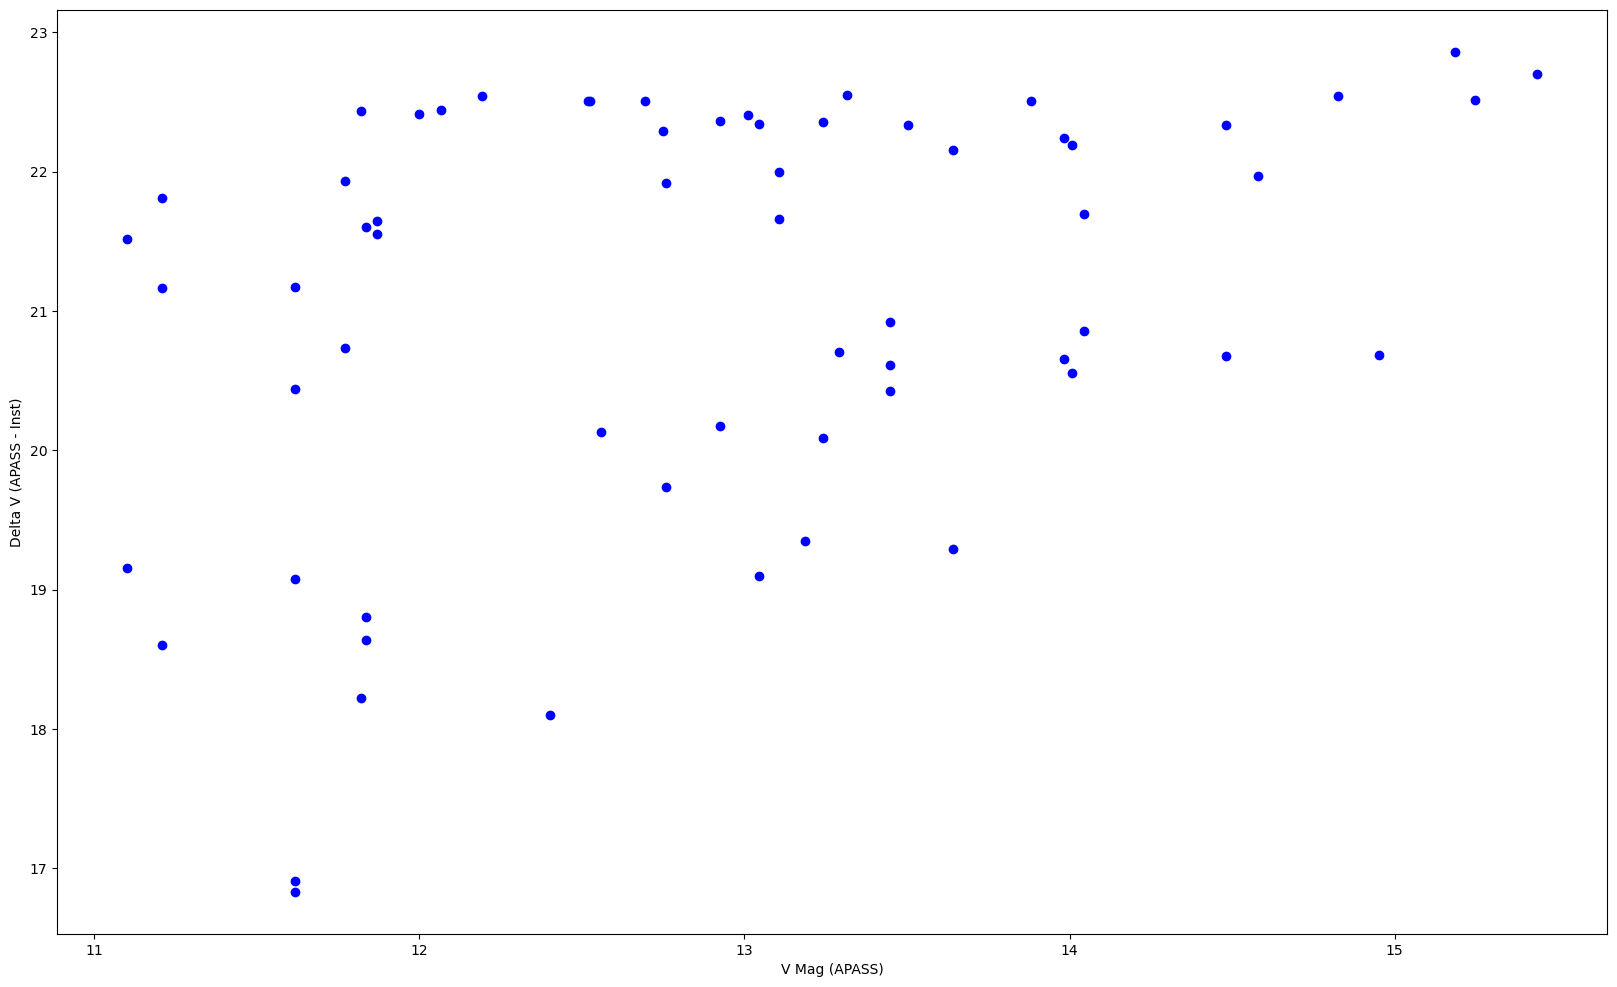

In [64]:
#doesnt work, dont use

import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.plot(xmatch['Vmag'],delta_mag, 'bo')
plt.xlabel('V Mag (APASS)')
plt.ylabel('Delta V (APASS - Inst)')
plt.show

The magnitude difference between instrumental and calibrated magnitude *should* be a constant, which is the value of $kX + m_{\rm zp}$. In the figure above, you can see there are plenty of outlying points, and the bright stars deviate from the constant. The outliers are either stars whose photometry is bad (poor sky estimation, or contaminated by very close stars), or spurious detections (i.e not stars). The deviation of the bright stars is caused because they are saturated, and so we cannot accurately measure their flux.

Since $m = m_i - kX + m_{\rm zp}$, we can find the value of $-kX + m_{\rm zp}$. - which I'll call the *zeropoint* from now on - by calculating the **median** difference between the instrumental and calibrated magnitude. The median will be robust against the outliers - but we only want to do it for the non-saturated stars!

# Calculate the zero-point

> Calculate the median value of ```delta_mag```. **If you have evidence for saturated stars**, you can use a NumPy *mask* to only calculate the median of stars that are not saturated 

> The median value of ```delta_mag``` is our estimate of $-kX + m_{\rm zp}$ - i.e the value we want to add to our instrumental magnitudes to get a calibrated magnitude. You can add this value to the **instrumental_mag** column of the VMag_inst table easily using ```VMag_inst['calibrated_mag'] = VMag_inst['instrumental_mag'] + zp```, where ```zp``` is the median value you found.

In [60]:
#ignore this cell b/c crossmatch no work

# First, just calculate the median:

zp = np.median(delta_mag)
print ('zeropoint = ', zp)

# We could also use a mask to exclude saturated points. Replace 21.5 and 21.0 
# with the upper/lower bounds of your 'good' data
plotmask = (delta_mag > 21.5) #& (delta_mag > 21.0)
delta_masked = delta_mag[plotmask]
zp1 = np.median(delta_masked)
print('Masked zeropoint = ',zp1)

zeropoint =  nan
Masked zeropoint =  22.3607722286704


In [92]:
# Now apply the zeropoint to the instrumental magnitudes
Vmag_inst['calibrated_mag'] = Vmag_inst['instrumental_mag'] + zeropoint

---------
# Other filters and making a CMD

If we repeat the above steps for other images, we can measure our stellar magnitudes in all of our other filters

# The B-band data

 Assuming that you started with V, repeat the steps for your B-band data. Make a plot of the difference between instrumental B-band magnitude and APASS B-band magnitude. Calculate the offset needed to correct your instrumental mags (zeropoint).

 Finally, add your zeropoint to the **instrumental_mag** column of the B-band table to make a new **calibrated_mag** column.

In [ ]:
# Grab the data
ifile = '/Users/evan/Documents/Research/galaxies/2023-07-20/Reduced/Data_files/d1072_os_bs_ff_bp_crj_crj.fits'
data, header = fits.getdata(ifile,header=True)

# Measure the background
mean_background, median_background, background_standard_deviation = sigma_clipped_stats(data, sigma=3.0)

print("The background has an average value of {:.1f} and a standard deviation of {:.1f} counts".format(
    mean_background, background_standard_deviation))

# Find the stars 
daofind = DAOStarFinder(fwhm=3.0, threshold=5*background_standard_deviation)
sources = daofind(data - median_background)
print(sources)

# Check everything looks good
radius=3
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=radius)
norm = ImageNormalize(data, interval=AsymmetricPercentileInterval(5, 95))
fig = plt.figure(figsize=(15, 12))
apertures.plot(color='red', lw=1.5, alpha=0.5)
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')

# Take a look at the FWHM in this image
measure_FWHM(data, sources)

# Time for photometry
Bmag_inst = aperture_photometry(data, header, sources, 10, 15, 25)



In [ ]:
# Now it's time for the crossmatch again
xmatch_b = XMatch.query(cat1=Bmag_inst, cat2='vizier:II/336/apass9', max_distance=2*u.arcsec, colRA1='RA', colDec1='DEC')
xmatch_b
# And calculate the difference between catalogue and instrument
delta_mag_b = xmatch_b['Bmag'] - xmatch_b['instrumental_mag']

In [ ]:
# Plot the delta mag for this filter
plt.figure(figsize=(20,12))
plt.plot(xmatch_b['Bmag'],delta_mag_b, 'bo')
plt.xlabel('B Mag (APASS)')
plt.ylabel('Delta B (APASS - Inst)')
plt.show

In [ ]:
# Calculate the zeropoint
zp_b = np.median(delta_mag_b)
print ('zeropoint = ', zp_b)

# Or use a mask if necessary
#plotmask = (delta_mag < 21.5) & (delta_mag > 21.0)
#delta_masked_b = delta_mag_b[plotmask]
#zp1_b = np.median(delta_masked_b)
#print('Masked zeropoint = ',zp1_b)

# And apply the zeropoint
Bmag_inst['calibrated_mag'] = Bmag_inst['instrumental_mag'] + zp_b

# Crossmatching our calibrated magnitudes

Now you should have a two astropy tables: One with calibrated V-band magnitudes and one with calibrated B-band magnitudes. We need to cross-match these tables with each other, to find which stars in the V-band table match with stars in the B-band table. We can't use ```astroquery```'s Xmatch for this, since they are both local tables. Instead, we will use the ```SkyCoord``` object from astropy, which is meant to work with coordinates on the sky. 



In [ ]:
from astropy.coordinates import SkyCoord
# Create a SkyCoord object for your first filter
coo_v = SkyCoord(Vmag_inst['RA'], Vmag_inst['DEC'], unit=u.deg)

# And for the second filter 
coo_b = SkyCoord(Bmag_inst['RA'], Bmag_inst['DEC'], unit=u.deg)

# match every entry in coo_v with the nearest entry in coo_b to identify the same stars in each catalogue
idx, distance_2d, distance_3d = coo_v.match_to_catalog_sky(coo_b)

# using idx as a slice for the Bmag_inst table will sort it so that Bmag_inst[0] is the closest match to Vmag_inst[0]
Bmag_inst = Bmag_inst[idx]

# And finally we have to ensure the closest match is actually useful. 
# Some of the 'closest matches' might actually be very far away. 
dist_mask = distance_2d < 3 * u.arcsec
Bmag_inst = Bmag_inst[dist_mask]
Vmag_inst = Vmag_inst[dist_mask]

# Plotting a CMD 

 If we want to plot a CMD from our data, we can extract the calibrated magnitudes, calculate ```B-V``` and plot a colour-magnitude diagram of ```B-V``` against ```V```. Your plot should look something like the one below, which is for the cluster NGC 7789.

<img src="./images/CMD.png" style="margin: 0px" width=750px/>


In [ ]:
B = Bmag_inst['calibrated_mag']
V = Vmag_inst['calibrated_mag']

plt.figure(figsize=(20,12))
plt.plot(B-V,V, 'bo')
plt.xlabel('B-V')
plt.ylabel('V Mag')
plt.gca().invert_yaxis()
plt.show

# Other filters

If you have data in other filters (and time!) you can go ahead and repeat the above steps for the other filters.


In [ ]:
# YOUR CODE HERE

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (250.48538117, 36.51048934)>
250.48538341981944 36.5105205701367
